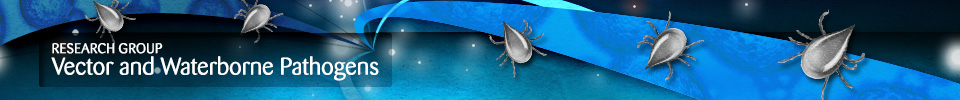

# 16S amplicon NGS

# Diversity and phylogenetic analysis

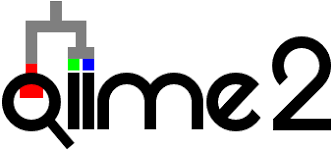

This workflow follows documentation from QIIME2 documents on [tutorials](https://docs.qiime2.org/2017.12/tutorials/) - mainly the moving pictures tutorial. 
<br>
<br>
***16S amplicon NGS analysis***

This notebook continues on from the notebook on data import & preliminary analysis, and native installation of QIIME2 following the USEARCH pipeline.

## Generate a tree for phylogenetic diversity analyses

QIIME supports several phylogenetic diversity metrics, including Faith’s Phylogenetic Diversity and weighted and unweighted UniFrac. In addition to counts of features per sample (i.e., the data in the `FeatureTable[Frequency]` QIIME 2 artifact), these metrics require a rooted phylogenetic tree relating the features to one another. This information will be stored in a `Phylogeny[Rooted]` QIIME 2 artifact. The following steps will generate this QIIME 2 artifact.

First, we perform a multiple sequence alignment of the sequences in our FeatureData[Sequence] to create a `FeatureData[AlignedSequence]` QIIME 2 artifact. Here we do this with the `mafft` program.

qiime alignment mafft \
--i-sequences sequences.qza \
--o-alignment aligned-sequences.qza

**Output artifacts:**

    aligned-sequences.qza

Next, we mask (or filter) the alignment to remove positions that are highly variable. These positions are generally considered to add noise to a resulting phylogenetic tree.

qiime alignment mask \
--i-alignment aligned-sequences.qza \
--o-masked-alignment masked-aligned-sequences.qza

**Output artifacts:**

    masked-aligned-sequences.qza

Next, we’ll apply FastTree to generate a phylogenetic tree from the masked alignment.

qiime phylogeny fasttree \
--i-alignment masked-aligned-sequences.qza \
--o-tree unrooted-tree.qza

**Output artifacts**

    unrooted-tree.qza

The FastTree program creates an unrooted tree, so in the final step in this section we apply midpoint rooting to place the root of the tree at the midpoint of the longest tip-to-tip distance in the unrooted tree.

qiime phylogeny midpoint-root \
--i-tree unrooted-tree.qza \
--o-rooted-tree rooted-tree.qza

**Output artifacts**

    rooted-tree.qza

***

# Alpha and beta diversity analysis

QIIME 2’s diversity analyses are available through the `q2-diversity` plugin, which supports computing alpha and beta diversity metrics, applying related statistical tests, and generating interactive visualizations. We’ll first apply the `core-metrics-phylogenetic` method, which rarefies a `FeatureTable[Frequency]` to a user-specified depth, computes several alpha and beta diversity metrics, and generates principle coordinates analysis (PCoA) plots using Emperor for each of the beta diversity metrics. The metrics computed by default are:

- Alpha diversity
    - Shannon’s diversity index (a quantitative measure of community richness)
    - Observed OTUs (a qualitative measure of community richness)
    - Faith’s Phylogenetic Diversity (a qualitiative measure of community richness that incorporates phylogenetic relationships between the features)
    - Evenness (or Pielou’s Evenness; a measure of community evenness)
- Beta diversity
    - Jaccard distance (a qualitative measure of community dissimilarity)
    - Bray-Curtis distance (a quantitative measure of community dissimilarity)
    - unweighted UniFrac distance (a qualitative measure of community dissimilarity that incorporates phylogenetic relationships between the features)
    - weighted UniFrac distance (a quantitative measure of community dissimilarity that incorporates phylogenetic relationships between the features)
    
    
An important parameter that needs to be provided to this script is `--p-sampling-depth`, which is the even sampling (i.e. rarefaction) depth. Because most diversity metrics are sensitive to different sampling depths across different samples, this script will randomly subsample the counts from each sample to the value provided for this parameter. For example, if you provide `--p-sampling-depth 500`, this step will subsample the counts in each sample without replacement so that each sample in the resulting table has a total count of 500. If the total count for any sample(s) are smaller than this value, those samples will be dropped from the diversity analysis. Choosing this value is tricky. We recommend making your choice by reviewing the information presented in the `table.qzv` file that was created above and choosing a value that is as high as possible (so you retain more sequences per sample) while excluding as few samples as possible.



<div class="alert alert-block alert-success"> **Question** <br></br>




View the `table.qzv` QIIME 2 artifact, and in particular the Interactive Sample Detail tab in that visualization. What value would you choose to pass for `--p-sampling-depth`? How many samples will be excluded from your analysis based on this choice? How many total sequences will you be analyzing in the `core-metrics-phylogenetic` command?</div>

qiime diversity core-metrics-phylogenetic \
  --i-phylogeny rooted-tree.qza \
  --i-table feature-table-1.qza \
  --p-sampling-depth 500 \ #adjust this number as required for your data 
  --m-metadata-file sample-metadata.tsv \
  --output-dir core-metrics-results

**Output artifacts:**
```
- core-metrics-results/bray_curtis_distance_matrix.qza
- core-metrics-results/bray_curtis_pcoa_results.qza
- core-metrics-results/evenness_vector.qza
- core-metrics-results/faith_pd_vector.qza
- core-metrics-results/jaccard_distance_matrix.qza
- core-metrics-results/jaccard_pcoa_results.qza
- core-metrics-results/observed_otus_vector.qza
- core-metrics-results/rarefied_table.qza
- core-metrics-results/shannon_vector.qza
- core-metrics-results/unweighted_unifrac_distance_matrix.qza
- core-metrics-results/unweighted_unifrac_pcoa_results.qza
- core-metrics-results/weighted_unifrac_distance_matrix.qza
- core-metrics-results/weighted_unifrac_pcoa_results.qza
```

**Output visualizations:**
```
- core-metrics-results/bray_curtis_emperor.qzv
- core-metrics-results/jaccard_emperor.qzv
- core-metrics-results/unweighted_unifrac_emperor.qzv
- core-metrics-results/weighted_unifrac_emperor.qzv
```

After computing diversity metrics, we can begin to explore the microbial composition of the samples in the context of the sample metadata. This information is present in the sample metadata fie.

We’ll first test for associations between discrete metadata categories and alpha diversity data. We’ll do that here for the Faith Phylogenetic Diversity (a measure of community richness) and evenness metrics.

qiime diversity alpha-group-significance \
  --i-alpha-diversity core-metrics-results/faith_pd_vector.qza \
  --m-metadata-file metadata.tsv \
  --o-visualization core-metrics-results/faith-pd-group-significance.qzv

qiime diversity alpha-group-significance \
  --i-alpha-diversity core-metrics-results/evenness_vector.qza \
  --m-metadata-file metadata.tsv \
  --o-visualization core-metrics-results/evenness-group-significance.qzv

**Output visualizations:**

    core-metrics-results/evenness-group-significance.qzv
    core-metrics-results/faith-pd-group-significance.qzv

<div class="alert alert-block alert-success"> **Question** <br></br>


What discrete sample metadata categories are most strongly associated with differences in microbial community **richness**? Are these differences statistically different? </div>

<div class="alert alert-block alert-success"> **Question** <br></br>


What discrete sample metadata categories are most strongly associated with differences in microbial community **evenness**? Are these differences statistically different? </div>

If you have a continuous variable in your metadata (e.g., `DaysSinceExperimentStart`) then you can tested if these are correlated with alpha diversity. If you’re interested in performing those tests you can use the `qiime diversity alpha-correlation` command.

Next we’ll analyze sample composition in the context of discrete metadata using PERMANOVA (first described in Anderson (2001)) using the `beta-group-significance` command. The following commands will test whether distances between samples within a group, such as samples from the same host species, are more similar to each other then they are to samples from the hosts. If you call this command with the `--p-pairwise` parameter, as we’ll do here, it will also perform pairwise tests that will allow you to determine which specific pairs of groups (e.g., human vs dog hosts) differ from one another, if any. This command can be slow to run, especially when passing `--p-pairwise`, since it is based on permutation tests. So, unlike the previous commands, we’ll run this on specific categories of metadata that we’re interested in exploring, rather than all metadata categories that it’s applicable to. Here we’ll apply this to our unweighted UniFrac distances, using two sample metadata categories (`Host` and `TickSpecies`), as follows.

qiime diversity beta-group-significance \
  --i-distance-matrix core-metrics-results/unweighted_unifrac_distance_matrix.qza \
  --m-metadata-file metadata.tsv \
  --m-metadata-category Host \
  --o-visualization core-metrics-results/unweighted-unifrac-Host-significance.qzv \
  --p-pairwise

qiime diversity beta-group-significance \
  --i-distance-matrix core-metrics-results/unweighted_unifrac_distance_matrix.qza \
  --m-metadata-file metadata.tsv \
  --m-metadata-category TickSpecies \
  --o-visualization core-metrics-results/unweighted-unifrac-TickSpecies-group-significance.qzv \
  --p-pairwise

**Output visualizations:**

    core-metrics-results/unweighted-unifrac-body-site-significance.qzv
    core-metrics-results/unweighted-unifrac-subject-group-significance.qzv

<div class="alert alert-block alert-success"> **Question** <br></br>


Are the associations between Tick species and differences in microbial composition statistically significant? How about hosts? What specific hosts/tick species are significantly different from each other? </div>

Again, none of the continuous sample metadata that we have for this data set are correlated with sample composition, so we won’t test for those associations here. If you’re interested in performing those tests, you can use the `qiime metadata distance-matrix` in combination with `qiime diversity mantel` and `qiime diversity bioenv` commands.

Finally, ordination is a popular approach for exploring microbial community composition in the context of sample metadata. We can use the [Emperor tool](http://biocore.github.io/emperor/) to explore principal coordinates (PCoA) plots in the context of sample metadata. While our `core-metrics-phylogenetic` command did already generate some Emperor plots, we want to pass an optional parameter, `--p-custom-axis`, which is very useful for exploring time series data. The PCoA results that were used in `core-metrics-phylogeny` are also available, making it easy to generate new visualizations with Emperor. We will generate Emperor plots for unweighted UniFrac and Bray-Curtis so that the resulting plot will contain axes for principal coordinate 1, principal coordinate 2, and days since the experiment start. We will use that last axis to explore how these samples changed over time - `DaysSinceAttachment`.

qiime emperor plot \
  --i-pcoa core-metrics-results/unweighted_unifrac_pcoa_results.qza \
  --m-metadata-file metadata.tsv \
  --p-custom-axis DaysSinceAttachment \
  --o-visualization core-metrics-results/unweighted-unifrac-emperor-DaysSinceAttachment.qzv

qiime emperor plot \
  --i-pcoa core-metrics-results/bray_curtis_pcoa_results.qza \
  --m-metadata-file metadata.tsv \
  --p-custom-axis DaysSinceAttachment \
  --o-visualization core-metrics-results/bray-curtis-emperor-DaysSinceAttachment.qzv

**Output visualizations:**

    core-metrics-results/bray-curtis-emperor-DaysSinceExperimentStart.qzv
    core-metrics-results/unweighted-unifrac-emperor-DaysSinceExperimentStart.qzv

<div class="alert alert-block alert-success"> **Question** <br></br>


Do the Emperor plots support the other beta diversity analyses we’ve performed here? (Hint: Experiment with coloring points by different metadata.) </div>

<div class="alert alert-block alert-success"> **Question** <br></br>


What differences do you observe between the unweighted UniFrac and Bray-Curtis PCoA plots? </div>

***

# Alpha rarefaction plotting

In this section we’ll explore alpha diversity as a function of sampling depth using the qiime diversity `alpha-rarefaction` visualizer. This visualizer computes one or more alpha diversity metrics at multiple sampling depths, in steps between 1 (optionally controlled with `--p-min-depth`) and the value provided as `--p-max-depth`. At each sampling depth step, 10 rarefied tables will be generated, and the diversity metrics will be computed for all samples in the tables. The number of iterations (rarefied tables computed at each sampling depth) can be controlled with `--p-iterations`. Average diversity values will be plotted for each sample at each even sampling depth, and samples can be grouped based on metadata in the resulting visualization if sample metadata is provided with the `--m-metadata-file` parameter.

qiime diversity alpha-rarefaction \
  --i-table feature-table-1.qza \
  --i-phylogeny rooted-tree.qza \
  --p-max-depth 10000 \
  --m-metadata-file metadata.tsv \
  --o-visualization alpha-rarefaction.qzv

**Output visualizations:**

    - alpha-rarefaction.qzv

The visualization will have two plots. The top plot is an alpha rarefaction plot, and is primarily used to determine if the richness of the samples has been fully observed or sequenced. If the lines in the plot appear to “level out” (i.e., approach a slope of zero) at some sampling depth along the x-axis, that suggests that collecting additional sequences beyond that sampling depth would not be likely to result in the observation of additional features. If the lines in a plot don’t level out, this may be because the richness of the samples hasn’t been fully observed yet (because too few sequences were collected), or it could be an indicator that a lot of sequencing error remains in the data (which is being mistaken for novel diversity).

The bottom plot in this visualization is important when grouping samples by metadata. It illustrates the number of samples that remain in each group when the feature table is rarefied to each sampling depth. If a given sampling depth `d` is larger than the total frequency of a sample `s` (i.e., the number of sequences that were obtained for sample `s`), it is not possible to compute the diversity metric for sample s at sampling depth `d`. If many of the samples in a group have lower total frequencies than `d`, the average diversity presented for that group at `d` in the top plot will be unreliable because it will have been computed on relatively few samples. When grouping samples by metadata, it is therefore essential to look at the bottom plot to ensure that the data presented in the top plot is reliable.

<div class="alert alert-block alert-info">**Note** <br></br>

The value that you provide for `--p-max-depth` should be determined by reviewing the “Frequency per sample” information presented in the `table.qzv` file that was created above. In general, choosing a value that is somewhere around the median frequency seems to work well, but you may want to increase that value if the lines in the resulting rarefaction plot don’t appear to be leveling out, or decrease that value if you seem to be losing many of your samples due to low total frequencies closer to the minimum sampling depth than the maximum sampling depth.</div>

<div class="alert alert-block alert-success"> **Question** <br></br>


When grouping samples by `Host` and viewing the alpha rarefaction plot for the `observed_otus` metric, which `Hosts` (if any) appear to exhibit sufficient diversity coverage (i.e., their rarefaction curves level off)? How many sequence variants appear to be present in those `Hosts`? </div>